# Numerical Exercises 8

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import math

csv_path = "./CSV/"
run_path = csv_path + "Run/"
calib_path = csv_path + "Calib/"
plt.rcParams['figure.figsize'] = [8, 5]

In this exercise I am going to apply an optimization technique known as Simulated Annealing (SA) on a simple (but without any analytic solution) one dimensional problem in quantum mechanics. This problem consists in finding the ground-state eigenfunction of the following Hamiltonian: $$\hat{H}(p,q)=\frac{\hat{p}^2}{2m}+V(q),\quad V(q)=q^4-\frac{5}{2}q^2$$
Instead of looking for the true ground-state eigenfunction in the whole $L^2$ function space, we can try to find an approximated function by optimizing some trial functions. This can be done since, by definition, the GS eigenfunction $\Psi_0$ of a system has the following property $$\langle {\hat H} \rangle_T = \frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}{\int dx |\Psi_T(x)|^2} \ge E_0 =\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}{\langle \Psi_0 | \Psi_0 \rangle}$$ where $\Psi_T(x)$ is a generic wave function labelled with $T$ and $E_0$ is the GS energy. The best approximation of $\Psi_0$ can then be obtained by finding the function $\Psi_T(x)$ in a specific $L^2$ subset that minimizes the left-hand side of the equation. In particular in this exercise we are looking for trial wave functions of the form $$\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}$$ where $\mu,\sigma$ are free parameters which are going to be the target of our optimization procedure.

## 8.1


As I previously said, in order to optimize these two parameters I implemented the simulated annealing algorithm. This algorithm works by treating the problem-specific cost function $L(\vec{x})$ (where $\vec{x}$ are the parameter to optimize) as the energy of a statistical-mechanics system. Therefore we can consider $L(\vec{x})$ to be distributed along a Boltzmann distribution $p(\vec{x})=\frac{e^{-\beta L(\vec{x})}}{Z}$ which we can sample using the Metropolis algorithm as follows:

1. Generate a new configuration $\vec x'$ using a uniform transition probability
2. Evaluate $L(\vec x')$
3. Accept the move with probability $min\left(1, \frac{p(\vec{x}')}{p(\vec{x}}\right)$

This is valid for a fixed value of $\beta$, but if we update the fictitious temperature $T=\frac{1}{\beta}$ toward lower values we can "freeze" the system around the configuration in which $L(\vec x)$ is minimum (and $p(\vec x)$ is maximum). Furthermore, I also modified the SA Metropolis step to be smaller as $\beta$ increases, thus allowing a more precise exploration around the actual minimum configuration.

It is now straightforward to specialize the SA algorithm to our problem by identifying $\vec x \rightsquigarrow (\mu,\sigma)$ and $L(\vec x)\rightsquigarrow E_{T}^{(\sigma,\mu)}$. In our final code we will then have two Metropolis algorithm, one for the SA and one to compute $E_T^{(\sigma,\mu)}$ as follows:
$$E_{T}^{(\sigma,\mu)}=\langle {\hat H} \rangle_T = \frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}{\int dx |\Psi_T(x)|^2} = \int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2}\frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$$

For this latter Metropolis algorithm is crucial to minimize the error and maximize the efficiency, since the evaluation of $E_{T}^{(\sigma,\mu)}$ is needed in each attempted move for the SA Metropolis. I then evaluated the error as a function of steps per block $L$ (using a total of $M = 2\cdot10^4$ steps) using the same code from Lab7.

In [42]:
def Error(sum, sum2, iblk):

    return math.sqrt(abs(sum2 - sum ** 2) / iblk)

# No need to calculate the error for each block, but only the last block error

def ComputeFinalBlockError(in_data, M, L):

    N = int(M / L)       # Number of blocks

    sum = 0.0
    sum2 = 0.0

    for i in range(0, N):

        # Faster than for loop
        blk_avg = np.sum(in_data[(i * L):((i + 1) * L - 1)]) / L

        sum += blk_avg 
        sum2 += (blk_avg ** 2)

    sum /= N
    sum2 /= N

    return Error(sum, sum2, N)

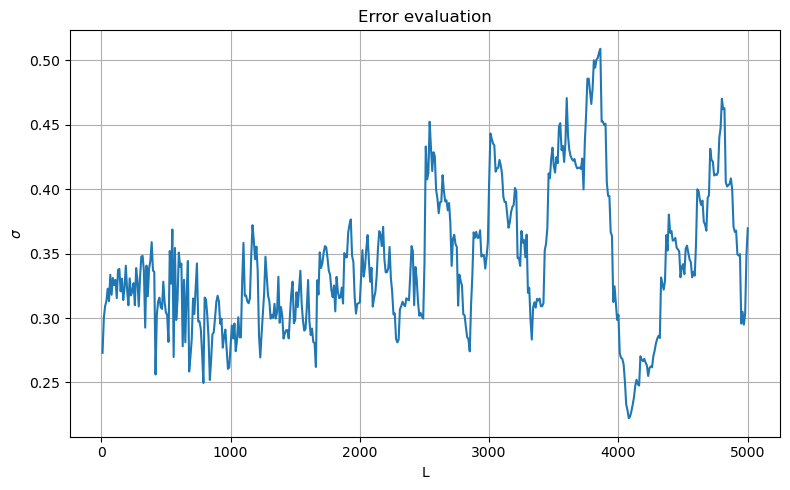

In [43]:
calib_data = np.loadtxt(calib_path + "E.csv", delimiter=',')

M = 2e4
L_min = 10
L_max = int(5e3)
L_range = range(L_min, L_max + 1, 10)       # Step 10 not to overcrowd graph

last_blk_errors = []

for L in L_range:

    last_blk_errors.append(ComputeFinalBlockError(calib_data[:, 1], M, L))

plt.plot(L_range, last_blk_errors)
plt.xlabel("L")
plt.ylabel(r"$\sigma$")
plt.title("Error evaluation")
plt.grid(True)

plt.tight_layout()
plt.show()

An optimal choice for L is something around $500$ s/b, where the error has already stabilized without exploding because of an insufficient number of block. I then chose to use $40$ blocks with $500$ s/b.

The only remaining variables we have to define are:

- $\delta$, $\Psi(x)$ sampling step
- $\Psi(x)$ sampling starting point
- $\mu, \sigma$ starting points.
- $T$ update law and extrema 
- $\delta_{SA}$, SA step
- Number of SA steps $L_{SA}$ and number of SA iterations $N_{SA}$.

The first one is tuned so that the acceptance rate in the $\Psi$ sampling is around $50\%$, in particular I found $\delta=2.0$. All the other parameters will be discussed in the next section.

## 8.2

First of all I tuned $L_{SA}$ and $N_{SA}$; since we are not computing any average value here (we only care about $\mu$ and $\sigma$ instantaneous values), this parameters should only be tuned keeping in mind two important aspects:
- The cooling procedure should be slow, otherwise the system could get stuck in a high-energy state.
- $L_{SA}$ should be large enough to allow for exploration of the parameter space but not too large to cause inefficiency.

I then chose to use $N_{SA}=100$, $L_{SA}=100$. A similar argument holds for $\delta_{SA}$: since here we do not care about the acceptance rate (in fact at lower $T$ we do want the acceptance rate to be very low), the only important fact is to have this parameter large enough to allow for a decent exploration in the first SA stages. At first I tried with $\delta_{SA}=0.8$ but the system was clearly stuck in a local minimum; after increasing it to $\delta_{SA}=1.2$ the problem was fixed, so I kept this last value.

Before choosing the best $T$ update law, I empirically started from a linear update law (i.e. at each SA step $T'=T-dT$ with $dT$ fixed) in order to find the best starting parameters both for SA and for $\Psi$ sampling. From these simulations I almost always obtained $\mu\approx1.0, \sigma\approx1.0$, so I decided to set the initial values $\mu_0=1.0, \sigma_0=1.0$. Recalling how we defined $\Psi_T^{(\mu,\sigma)}$, I then decided to start its sampling not too far away from the maximum probability region, namely at $x_0=2.0$. This also allowed me to utilize a low number of equilibration step ($50$) before each energy evaluation, thus speeding up the code execution.

At last I concentrated on the $T$ update law trying three different laws:

1. Linear, already described
2. Power, $T'=T\cdot dT$
3. Beta, $\beta'=\beta+d\beta$

After some test changing both the update law and its extrema I found out that:

1. T update law: 
    - Does work (especially the power law update, linear is a bit too messy), but gives less accurate results and generally seems less "natural" than a beta update law.
2. Beta update law:    
    - $1.0$ is a good minimum value
    - $10^6$ as maximum value is too strict, no time to equilibrate
    - $10^2$ as maximum value yielded good results, but too much oscillating 
    - $10^3$ seems a good balance

Therefore in the final simulation I used a $\beta$ update law with extrema $1.0$ and $10^3$.

I then simulated the system, obtaining the results below (note that since the system is symmetric under a change of sign in $\mu,\sigma$ these can also be negative).

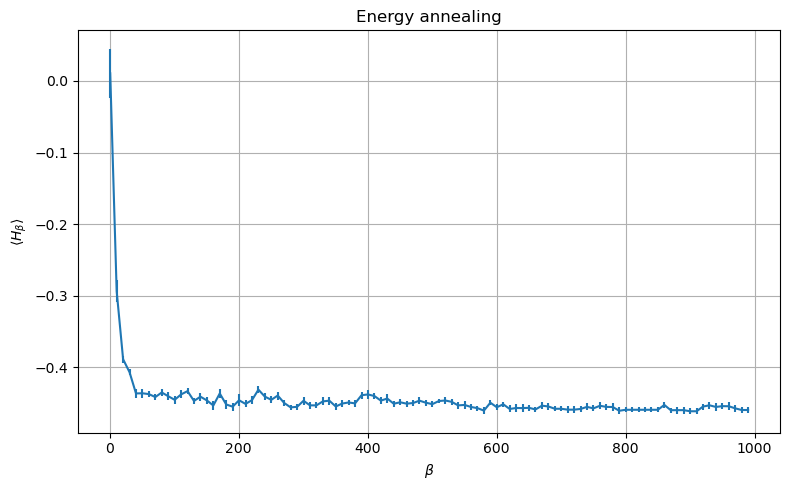

Mu: -0.80333	Sigma: -0.620515


In [44]:
E_data = np.loadtxt(run_path + "SA_E.csv", delimiter=',')

plt.errorbar(1.0 / E_data[:, 0], E_data[:, 1], yerr = E_data[:, 2])
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\langle H_\beta \rangle$")
plt.title("Energy annealing")
plt.grid(True)
plt.tight_layout()
plt.show()

out_params = np.loadtxt(run_path + "SA_params.csv", delimiter = ',')

mu = out_params[0]
sigma = out_params[1]

print("Mu: {}\tSigma: {}".format(mu, sigma))

As we can see the procedure does indeed work, in fact we have a huge average energy decrease in the first $50$ steps followed by a stable behavior characterized by small adjustments in the latter steps (which is exactly the expected behavior at high $\beta$). Theoretically I could improve the result by letting the code run for a longer number of SA steps, but the results where already promising so I decided to stop the process here.

Once I obtained the optimal value for $\mu$ and $\sigma$, I computed the final energy. To do this I used data-blocking with $100$ block and $1000$ s/b. The final state energy, alongside its error, is graphed below as a function of the block number. I also solved the problem numerically and printed the predicted energy.

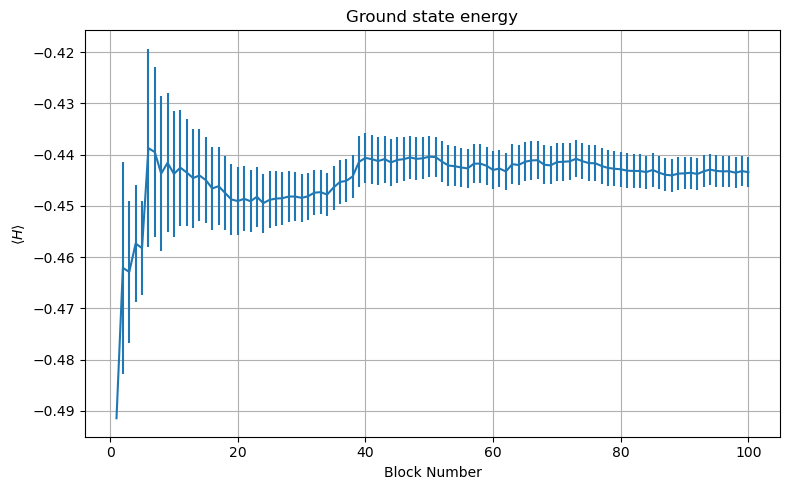

MC COMPUTATION
Ground state energy: -0.44346	Error: 0.00295664


In [45]:
E_final = np.loadtxt(run_path + "E_final.csv", delimiter=',')

plt.errorbar(E_final[:, 0], E_final[:, 2], yerr = E_final[:, 3])
plt.xlabel("Block Number")
plt.ylabel(r"$\langle H \rangle$")
plt.title("Ground state energy")
plt.grid(True)
plt.tight_layout()
plt.show()

print("MC COMPUTATION")
print("Ground state energy: {}\tError: {}".format(E_final[-1,2], E_final[-1,3]))

In [46]:
def Vpot(x):
    return (x**2 - 2.5)*x**2

hbar = 1
m = 1
a = 10
N = 1000 

x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] 
V = Vpot(x)

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

E,psi = np.linalg.eigh(H)

psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("NUMERICAL COMPUTATION")
print("Ground state energy: ", E[0])

scale = 0.3

NUMERICAL COMPUTATION
Ground state energy:  -0.4604658796927155


The two results are clearly not compatible, with the energy obtained via Monte Carlo simulation being higher then the energy obtained via a Numerical (lattice) simulation. This, anyway, is expected, since the numerical approach does not rely on any hypothesis on the form of $\Psi_0$, while the optimization problem only works with a specific class of trial functions. Anyway, even with this discrepancy, I can say that the results obtained via MC simulation are still quite good considering all the limitations we externally imposed on $\Psi_0$.

In [47]:
def psi_SA(x, mu, sigma):

    return (np.exp(-0.5 * ((x - mu) / sigma) ** 2) + np.exp(-0.5 * ((x + mu) / sigma) ** 2))

# Psi^2 normalization (numerically computed)
psi_sqrd_norm = 2.61126

To highlight this result, I dumped some data from the sampling of the optimized wave-function $\Psi_{Opt}$ (I divided the interval $[-3,3]$ into $100$ bins and filled an histogram by counting the number of points in each sub-interval) and then I constructed a plot with these data, the exact $\Psi_{Opt}$ and the GS wave function obtained via numerical simulation.

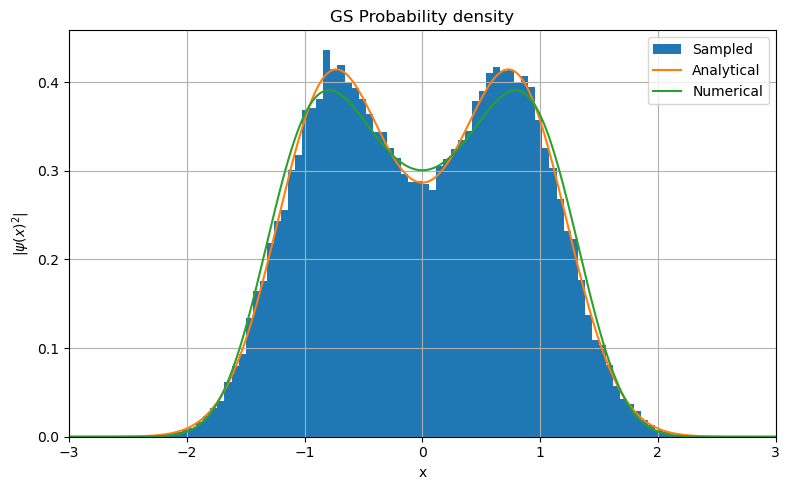

In [48]:
hist_data = np.loadtxt(run_path + "final_hist.csv", delimiter = ',')
out_params = np.loadtxt(run_path + "SA_params.csv", delimiter = ',')

mu = out_params[0]
sigma = out_params[1]

plt.hist(hist_data[0,:], bins = hist_data[0,:], weights = hist_data[1,:], density = True, label = "Sampled")
plt.plot(x, psi_SA(x, mu, sigma) ** 2 / psi_sqrd_norm, label = "Analytical")
plt.plot(x,(psi[0])**2, label = "Numerical")
plt.xlabel("x")
plt.ylabel(r"$|\psi(x)^2|$")
plt.title("GS Probability density")
plt.grid(True)
plt.xlim((-3,3))
plt.legend()
plt.tight_layout()
plt.show()

As we can see the sampling of $\Psi_{Opt}$ is indeed correct, but this wave-function is still quite different from the one obtained via numerical simulation. Again, this is mainly due to the fact that we are limiting our MC research on a small subset of $L^2$.

Finally, to better visualize the SA evolution, I plotted the energy trajectory in the parameter space and the parameter trajectory as a function of the SA step.

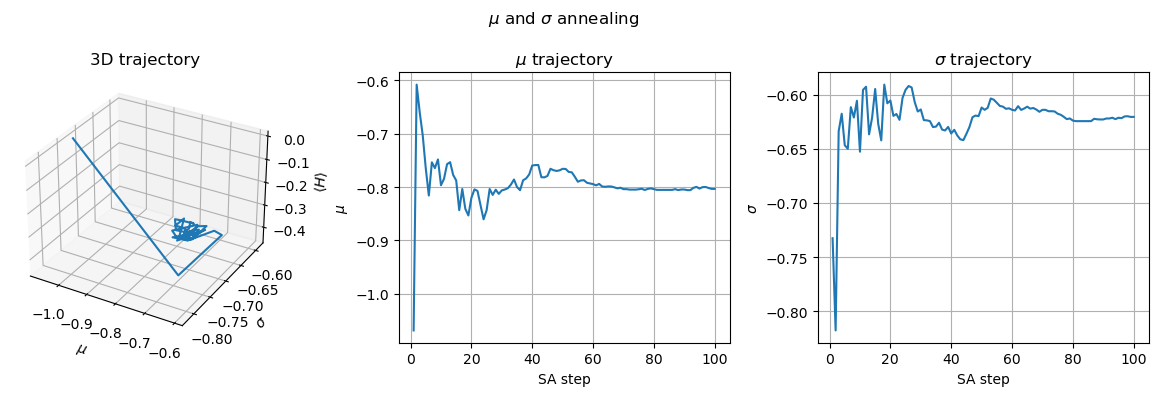

In [49]:
SA_evol_data = np.loadtxt(run_path + "SA_evol.csv", delimiter = ',')

X = SA_evol_data[:, 1]             # mu
Y = SA_evol_data[:, 2]             # sigma
Z = SA_evol_data[:, 0]             # energy

plt.figure().set_size_inches((12, 4))

plt.subplot(1, 3, 1, projection='3d')
plt.plot(X, Y, Z)
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma$")
plt.gca().set_zlabel(r"$\langle H \rangle$")
plt.title("3D trajectory")
plt.subplot(1, 3, 2)
plt.plot(np.arange(1, 101), X)
plt.xlabel("SA step")
plt.ylabel(r"$\mu$")
plt.title(r"$\mu$ trajectory")
plt.grid(True)
plt.subplot(1, 3, 3)
plt.plot(np.arange(1, 101), Y)
plt.xlabel("SA step")
plt.ylabel(r"$\sigma$")
plt.title(r"$\sigma$ trajectory")
plt.grid(True)

plt.suptitle(r"$\mu$ and $\sigma$ annealing ")
plt.tight_layout()
plt.show()

We can then say that the annealing process has proceeded steadily towards the final configuration, without getting stuck in any local minimum. Furthermore, from the three plots, it is clear that the exploration has eventually been concentrated around the final configuration, exactly as intended.